In [658]:
# betelfunctions
# One nice big python file with all of our functions!
#

import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt
import cmasher as cmr
from astropy.io import fits
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  

from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus

r_betelgeuse = 29.50*1e-3*u.arcsec


lowcolor = 'steelblue'
highcolor='crimson'

#defining constants for density model

def sm(dist, ang_size):
    '''
    takes ang size arsec
    distance pc
    returns diam in pc
    '''
    diam = (ang_size*dist)/206265

    return diam

def rp_annulus(data, pix_size_arcsec,position):
    '''
    data, pix size in arcsec, position of center star
    '''
    aperture_size = r_betelgeuse.value / pix_size_arcsec.value #put in pixel units
    aperture = CircularAperture(position,aperture_size)
    photometry = aperture_photometry(data,aperture)
    # print()
    # print("Photometry: ", photometry)

    aperture_sizes = np.arange(1,200,1)
    annuli=[CircularAnnulus(position, r_in=aperture_sizes[i], r_out=aperture_sizes[i+1]) for i in range(len(aperture_sizes)-1)]
    areas = np.array([circle.area for circle in annuli])*pix_size_arcsec**2
    # print(apertures)
    
    
    photometry = aperture_photometry(data, annuli)
    phot_list = []
    for k,v in photometry.items():
        if 'aperture_sum' in k:
            phot_list.append(v)
    phot_array = np.array(phot_list)
    #print(phot_list)
    surf_brightness_jy_arc2 = phot_array.flatten()*u.Jy / (areas)

    centers_arc = ((aperture_sizes[1:]+aperture_sizes[:-1])/2)*pix_size_arcsec
    centers_pc = sm(168,centers_arc).value*u.pc

    centers = {'pc': centers_pc, 'arc': centers_arc}

    return centers,surf_brightness_jy_arc2


def radial_read(filename,w,x2=0,y2=0):
    '''
    reads in file and returns radial profile and returns important data
    '''

    hdu_hr = fits.open(filename, mode= 'update')
    data_hr = hdu_hr[0].data
    header_hr = hdu_hr[0].header

    theta = header_hr['BPA']
    bmaj = header_hr['BMAJ']
    bmin = header_hr['BMIN']

    if filename==(low_file):
            header_hr['CRVAL1'] = 88.79303312

            header_hr['CRVAL2'] = 7.40710366

    ### CONVERTING DATA TO DIFFERENT UNITS
    beam = (header_hr['BMAJ'] * u.deg, header_hr['BMIN']*u.deg)
    pix_size = (np.abs(header_hr['CDELT1'])*u.deg,np.abs(header_hr['CDELT2'])*u.deg)
    pix_size_arcsec = pix_size[0].to(u.arcsec)
    beam_solid_angle = np.pi * beam[0] * beam[1] / (4*np.log(2))

    beam_solid_angle_arcsec2 = beam_solid_angle.to(u.arcsec**2).value # dividing by arcsec conversion to get from beam to arcsec
    pixels_per_beam = beam_solid_angle / (pix_size[0]*pix_size[1])

    data_jy_per_pixel = data_hr / pixels_per_beam

    ### GATHERING MEDIAN BACKGROUND DATA
    mean, median, std = sigma_clipped_stats(data_jy_per_pixel[0,0,...], sigma = 3.0)
    median_jy_per_arc2 = median /beam_solid_angle_arcsec2
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 5*std.value)
    sources = daofind(data_jy_per_pixel[0,0,...] - median.value)
    for col in sources.colnames:
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f' # for table formatting

    #data_jy_per_pixel-=median.value
    data_jy_per_arcsec2 = data_jy_per_pixel / beam_solid_angle_arcsec2


    ### PHOTOMETRY CALCUATION
    max_pos = np.unravel_index(np.argmax(np.ma.masked_invalid(data_jy_per_pixel)), data_jy_per_pixel.shape)
    print(max_pos)
    y = max_pos[-1]
    x = max_pos[-2]
    
    print(x,y)
    
    position = (x,y) #max_pos[-2], max[-1]
    if(x2!=0 and y2!=0):
        position = (x2,y2)

    centers, rp = rp_annulus(data_jy_per_pixel[0,0,...],pix_size[0].to(u.arcsec),position)

    ### RADIUS DATA IN 2D
    dimensions = data_jy_per_arcsec2[0,0,...].shape
    rows,columns = dimensions
    radius_2d = np.array([[0.0]*columns]*rows)
    x,y = w,w
    for i in range(rows):
        for j in range(columns):
            c = (x-i)**2+(y-j)**2
            radius_2d[i,j] = np.sqrt(c)

    radius_2d_arc = radius_2d*pix_size_arcsec.value
    radius_2d_pc = sm(168,radius_2d_arc)*u.pc

    ### GATHERING DATA IN DICTONARY LISTS

    data = {'jy/beam': data_hr[0,0,...],'jy/pixel': data_jy_per_pixel,'jy/arc2': data_jy_per_arcsec2}

    info = {'beam':beam, 'pix_size':pix_size, 'pix/beam': pixels_per_beam,'pix_size_arcsec': pix_size_arcsec, 'median_jy/beam': median, 
    		'median_jy/arc2': median_jy_per_arc2, 'theta': theta, 'bmaj': bmaj, 'bmin':bmin, 'header':header_hr,'position': position}

    rp = {'jy/arc2':rp}
    rp_radius = {'arc':centers['arc'],'pc':centers['pc']}
    radius_2d= {'arc':radius_2d_arc,'pc':radius_2d_pc}


    return data, info, rp, rp_radius, radius_2d


def radius2d(data):
    ### RADIUS DATA IN 2D
    dimensions = data.shape
    rows,columns = dimensions
    radius_2d = np.array([[0.0]*columns]*rows)
    x = rows/2
    y = rows/2
    for i in range(rows):
        for j in range(columns):
            c = (x-i)**2+(y-j)**2
            radius_2d[i,j] = np.sqrt(c)

    return radius_2d



In [611]:
#conv
import numpy as np

from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

from reproject import reproject_exact,reproject_adaptive
from astropy.wcs import WCS

from matplotlib import pyplot as plt
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus


lowcolor = 'steelblue'
highcolor='crimson'

def convolve_resamp(data_lr,data_hr,info_lr,info_hr):
    '''
    convolves and resamples
    '''

    bmaj_pix = info_lr['bmaj']/(info_hr['pix_size'][0].value)
    bmin_pix = info_lr['bmin']/(info_hr['pix_size'][0].value)

    print("bmajpix, bminpix: ",bmaj_pix,bmin_pix)

    bmaj_sigma = bmaj_pix/(2*np.sqrt(2*np.log(2)))
    bmin_sigma = bmin_pix/(2*np.sqrt(2*np.log(2)))

    print("bmajsigma, bminsigma: ",bmaj_sigma,bmin_sigma)

    gaussian_2D_kernel = Gaussian2DKernel(x_stddev=bmaj_sigma, y_stddev=bmin_sigma, theta = info_lr['theta'], mode = 'oversample')

    convolved_hr_pix = convolve(data_hr['jy/pixel'][0,0], gaussian_2D_kernel) 
    print("convolution complete.")

    beam_solid_angle_hr = np.pi * info_hr['beam'][0] * info_hr['beam'][1] / (4*np.log(2))
    beam_solid_angle_lr = np.pi * info_lr['beam'][0] * info_lr['beam'][1] / (4*np.log(2))

    #convolved_hr_jy_arc2 = convolved_hr_pix / beam_solid_angle_hr.to(u.arcsec**2).value

    wcs_hr = WCS(info_hr['header'])
    wcs_lr = WCS(info_lr['header'])

    print("starting reprojection...")

    #reproj_hr_pix, footprint = reproject_exact((convolved_hr_pix[np.newaxis,np.newaxis], wcs_hr.celestial), wcs_lr.celestial)
    reproj_hr_pix, footprint = reproject_adaptive((convolved_hr_pix[np.newaxis,np.newaxis], wcs_hr.celestial), wcs_lr.celestial,
                                conserve_flux=True)
    reproj_hr_jy_arc2 =(reproj_hr_pix /beam_solid_angle_lr.to(u.arcsec**2).value)

    reproj_hr_pixel_norm = reproj_hr_pix*np.nanmax(data_lr['jy/pixel'])/np.nanmax(reproj_hr_pix) #normalizing
    reproj_hr_jy_arc2_norm =(reproj_hr_pixel_norm /beam_solid_angle_lr.to(u.arcsec**2).value)

    print("data_hr: ",np.nansum(data_hr['jy/pixel']))
    print("convovled_hr_pix: ",np.nansum(convolved_hr_pix))

    print("reproj_hr_pix: ",np.nansum(reproj_hr_pix))
    print("reproj_hr_pix_norm: ",np.nansum(reproj_hr_pixel_norm))
    print()
    print("reproj_hr_arc: ",np.nansum(reproj_hr_jy_arc2))
    print("reproj_hr_arc_norm: ",np.nansum(reproj_hr_jy_arc2_norm))


    max_pos = np.unravel_index(np.argmax(np.ma.masked_invalid(reproj_hr_pixel_norm[0,0,...])), reproj_hr_pixel_norm.shape)
    y = max_pos[-1]
    x = max_pos[-2]

    position_conv = (x,y)

    ### GATHERING MEDIAN BACKGROUND DATA
    mean_cv, median_cv, std_cv = sigma_clipped_stats(reproj_hr_pixel_norm[0,0,...], sigma = 3.0)
    # print("Mean, meadian, std: ", mean, median, std)

    daofind = DAOStarFinder(fwhm = 3.0, threshold = 5*std_cv.value)
    print(type(median_cv),type(reproj_hr_pixel_norm))
    sources = daofind(reproj_hr_pixel_norm[0,0,...] - median_cv)
    for col in sources.colnames:
        if col not in ('id', 'npix'):
            sources[col].info.format = '%.2f' # for table formatting
    sources.pprint(max_width=-1)

    x=int(info_lr['position'][0])
    y=int(info_lr['position'][1])
    w=400
    data_lr_centered = data_lr['jy/pixel'][0,0,x-w:x+w,y-w:y+w]
    print(x,y)
    reproj_hr_pixel_centered = reproj_hr_pixel_norm[0,0,position_conv[0]-w:position_conv[0]+w,position_conv[1]-w:position_conv[1]+w]
    print(position_conv)

    plt.title("data_lr_centered")
    plt.imshow(data_lr_centered.transpose())
    err=5
    plt.plot(w,w,'rx')
    plt.xlim(w-err,w+err)
    plt.ylim(w-err,w+err)
    plt.colorbar()
    plt.show()

    plt.title("reproj_hr_pixel_centered")
    plt.imshow(reproj_hr_pixel_centered.transpose())
    plt.plot(w,w,'rx')
    plt.xlim(w-err,w+err)
    plt.ylim(w-err,w+err)
    plt.colorbar()
    plt.show()

    csm = data_lr_centered - (reproj_hr_pixel_centered)
    #csm = data_lr['jy/pixel'][0,0,...]-reproj_hr_pixel_norm[0,0,...]

    
    csm_jy_arc = csm/(beam_solid_angle_lr.to(u.arcsec**2).value)

    # plt.plot(data_lr_centered, label = 'lr', c = lowcolor)
    # plt.plot(reproj_hr_pixel_centered, label = 'hrconv', c='maroon')
    # plt.plot(csm, 'o-', label='CSM', zorder=9,c='purple')
    # plt.legend()

    # plt.xlim(0,1.5)
    # plt.semilogy()
    # plt.show()

    print("stop 2")

    plt.imshow(csm.value, origin = 'lower',cmap = 'PRGn')
    plt.title("CSM")
    plt.plot(w, w,'rx')
    plt.plot(info_hr['position'][0],info_hr['position'][1],'o')
    plt.colorbar()
    plt.xlim(w-25,w+25)
    plt.ylim(w-25,w+25)
    plt.show()

    print("stop 3")
    
    data_conv_norm = {'jy/arc2': reproj_hr_jy_arc2_norm, 'jy/pixel': reproj_hr_pixel_norm}
    data_conv = {'jy/arc2': reproj_hr_jy_arc2,'jy/pixel': reproj_hr_pix}
    data_centered = {'lr': data_lr_centered,'convhr':reproj_hr_pixel_centered}
    data_csm = {'jy/arc2':csm_jy_arc, 'jy/pix': csm}

    info_conv = {'position': position_conv, 'median': median_cv}


    return data_conv_norm, data_conv, data_centered, data_csm, info_conv
    
    

In [514]:
#density
import numpy as np
from astropy.modeling.models import BlackBody
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()  

r_betelgeuse = 29.50*1e-3*u.arcsec
beta= 1.4
k160 = 8.8*u.cm**2 *u.g**-1
stellar_radius_hr_pc = (0.035*168/206265)*u.parsec
rhr = stellar_radius_hr_pc #pc hr radius
lmda = 887.0*u.um #microns
lmda_cm = 0.0887*u.cm
lmda_AA = 8.87e6*u.AA


def density_model(Sarr, Rarr, pr = False):
    '''
    turns intensity into density. 
    lmda = wavelength
    Sarr = intensity array profile
    Rarr = radii
    p = print. do you want to print Sarr kpa and B before printing?
    '''
    T = temp(Rarr,pr)

    B = BlackBody(temperature = T)
    kpa = kappa(lmda)

    B=B(lmda_AA)
    arcsec2_per_sr=4.25e10*u.arcsec**2/u.sr
    ergcmshz_per_jy = 1.0e-23*u.erg/u.cm**2/u.s/u.Hz/u.Jy

    B_jy_arcsec2 = B/arcsec2_per_sr/ergcmshz_per_jy
    

    sigma= Sarr/ (kpa*B_jy_arcsec2)

    if pr==True:
        print("Sarr :", Sarr)
        print("kpa :",kpa)
        print("B: ", B_jy_arcsec2)

    return sigma

def kappa(lmda):
    k = k160*(lmda/(160*u.um))**(-1*beta)
    return k


def temp(Rarr, pr=False):
    Tin = 1300.0*u.K
    Rin = 3* rhr
    Rarr_shape = np.shape(Rarr)
    t_cap = 3000*u.K

    if len(Rarr_shape) == 1: #1D
        T = [0.0*u.K]*len(Rarr)
        for i in range(len(Rarr)):
            #T[i] = Tin*((Rarr[i]/Rin)**(-1/2))
            T[i] = np.minimum(t_cap ,Tin*((Rarr[i]/Rin)**(-1/2)))
    elif len(Rarr_shape)==2: #2D len(Rarr_shape==2)
        row, col = Rarr_shape
        T = np.array([[0.0]*col]*row)*u.K
        for i in range(row):
            for j in range(col):
                T[i][j] = np.minimum(t_cap ,Tin*((Rarr[i][j]/Rin)**(-1/2)))
    else: #single value
        T = np.minimum(t_cap ,Tin*((Rarr/Rin)**(-1/2)))
        if pr==True:
            print("T :", T)

    return T

In [651]:
from astropy.time import Time
from astropy.coordinates import SkyCoord

In [652]:
pm_ra = 26.42 * u.mas/u.yr
pm_dec = 9.60 * u.mas/u.yr
hr_time = Time('2015-11-06')
lr_time = Time('2016-08-16')
crval_hr = [88.79306115045,7.407113577698]*u.deg
crval_lr = [88.7930685989, 7.407116442487]*u.deg
distance = 168*u.parsec
c = SkyCoord(ra=crval_lr[0],
             dec=crval_lr[1],
             distance=distance,
             pm_ra_cosdec=26.42 * u.mas/u.yr,
             pm_dec=9.60 * u.mas/u.yr,
             obstime=Time(Time('2020-08-22')))
Time('2020-08-22')
c.apply_space_motion(hr_time) 

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (88.79303312, 7.40710366, 168.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (26.41999923, 9.60000211, -1.46260001e-05)>

In [654]:
info_lr['header']['CRVAL1'] = 88.79303312

info_lr['header']['CRVAL2'] = 7.40710366

(0, 0, 1273, 1290)
1273 1290


(0, 0, 439, 442)
439 442
(439, 442)
(882, 882)


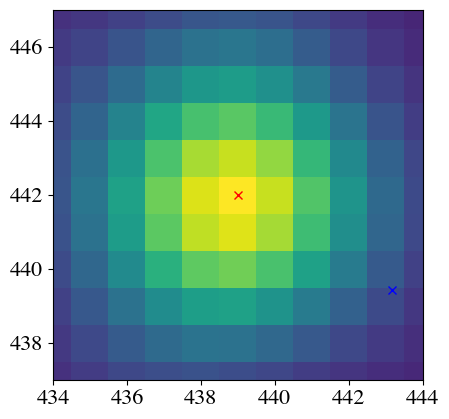

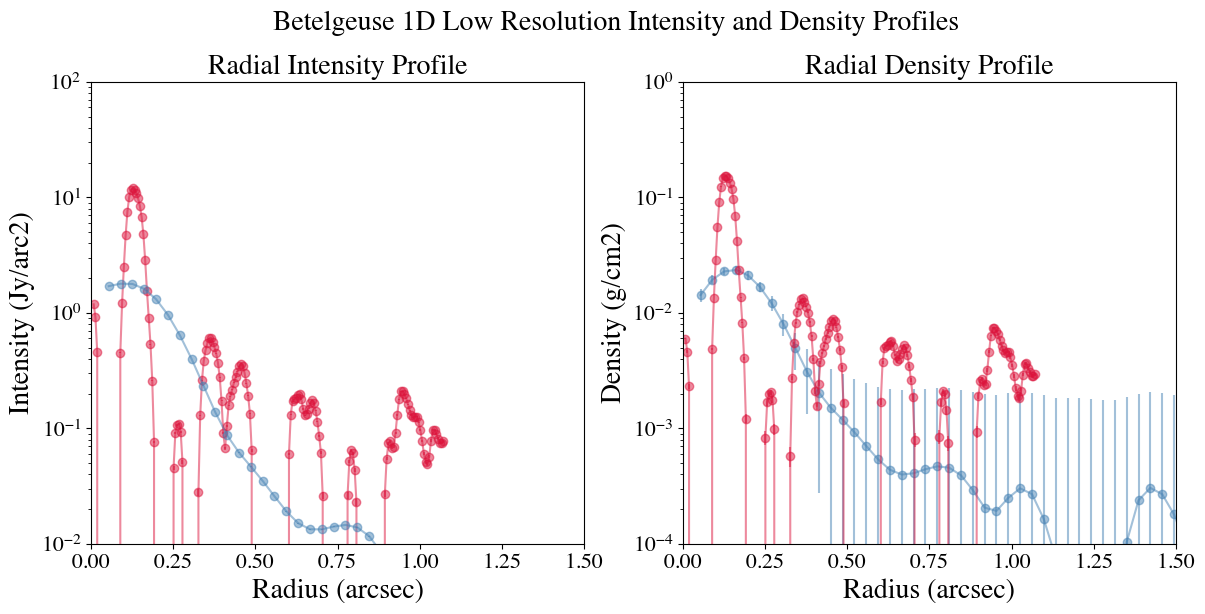

In [659]:
# data read in
low_file = "member.uid___A001_X2fb_X200.ari_l.Betelgeuse_sci.spw0_1_2_3_4_338083MHz.12m.cont.I.pbcor.fits"
high_file = "hr_member.uid___A001_X2de_Xf7.ari_l.Betelgeuse_sci.spw0_1_2_3_4_338086MHz.12m.cont.I.pbcor.fits"


data_hr,info_hr,rp_hr,hr_rp_radius,hr_radius_2d = radial_read(high_file, 100)
data_lr,info_lr,rp_lr,lr_rp_radius,lr_radius_2d = radial_read(low_file, 100)#,x2=int(439+0.26666667),y2=int(443-0.73388889))

print(info_lr['position'])

num_1d_model_hr = density_model(rp_hr['jy/arc2'].value,(hr_rp_radius['pc']))
num_1d_model_lr = density_model(rp_lr['jy/arc2'].value,(lr_rp_radius['pc']))

print(data_lr['jy/beam'].shape)
plt.imshow(data_lr['jy/beam'].transpose())
err=5
plt.plot(info_lr['position'][0],info_lr['position'][1],'rx')
plt.plot(443.16,439.41,'bx')
plt.xlim(info_lr['position'][0]-err,info_lr['position'][0]+err)
plt.ylim(info_lr['position'][1]-err,info_lr['position'][1]+err)
plt.show()

lowcolor = 'steelblue'
highcolor='crimson'


plt.style.use("default")
plt.rcParams["font.family"] = "times"
plt.rcParams.update({'font.size': 16})
text_size = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [14,6])
fig.suptitle('Betelgeuse 1D Low Resolution Intensity and Density Profiles',size = 20,y=1)

ax1.errorbar(hr_rp_radius['arc'],rp_hr['jy/arc2'].value,yerr= np.abs(info_hr['median_jy/arc2'].value),color=highcolor,label = 'High Res',zorder = 0, alpha=0.5,fmt='-o')
ax1.errorbar(lr_rp_radius['arc'],rp_lr['jy/arc2'].value,yerr = np.abs(info_lr['median_jy/arc2'].value),color=lowcolor,label = 'Low Res',zorder=0, alpha=0.5,fmt= 'o-')
ax1.semilogy()
ax1.set_xlim(0, 1.5)
ax1.set_ylim(1e-2,1e2)

ax1.set_title("Radial Intensity Profile",size=text_size)
ax1.set_xlabel("Radius (arcsec)",size=text_size)
ax1.set_ylabel("Intensity (Jy/arc2)",size=text_size)

ax2.set_title("Radial Density Profile",size=text_size)
ax2.errorbar(lr_rp_radius['arc'],num_1d_model_lr.value, yerr = np.abs(info_hr['median_jy/arc2'].value), color = lowcolor,zorder = 0, alpha=0.5,fmt='-o')
ax2.errorbar(hr_rp_radius['arc'],num_1d_model_hr.value, yerr = np.abs(info_lr['median_jy/arc2'].value), color = highcolor,zorder=0, alpha=0.5,fmt= 'o-')
ax2.set_xlabel("Radius (arcsec)",size=text_size)
ax2.set_ylabel("Density (g/cm2)",size=text_size)
ax2.semilogy()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(1e-4,1)
plt.show()

In [660]:
data_lr['jy/beam'][439,443]

0.23721354

()


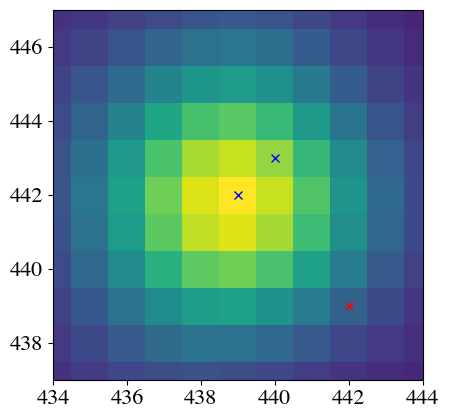

In [661]:
print(data_lr['jy/beam'][0,0,...].shape)
plt.imshow(data_lr['jy/arc2'][0,0,...].transpose())
err=5
plt.plot(info_lr['position'][1],info_lr['position'][0],'rx')
plt.plot(440,443,'bx')
plt.plot(439,442,'bx')
plt.xlim(info_lr['position'][0]-err,info_lr['position'][0]+err)
plt.ylim(info_lr['position'][1]-err,info_lr['position'][1]+err)
plt.show()

lowcolor = 'steelblue'
highcolor='crimson'

(2560, 2560)


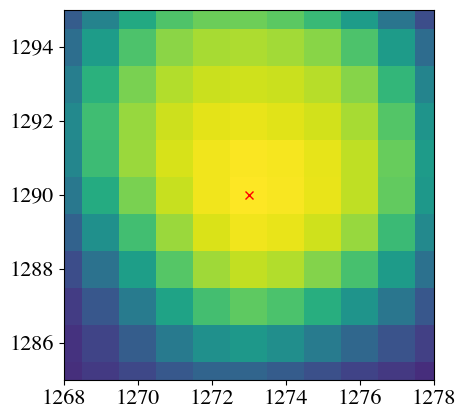

In [662]:
print(data_hr['jy/beam'].shape)
plt.imshow(data_hr['jy/beam'].transpose())
err=5
plt.plot(info_hr['position'][0],info_hr['position'][1],'rx')
#plt.plot(1273,1290,'bx')
plt.xlim(info_hr['position'][0]-err,info_hr['position'][0]+err)
plt.ylim(info_hr['position'][1]-err,info_hr['position'][1]+err)
plt.show()

lowcolor = 'steelblue'
highcolor='crimson'

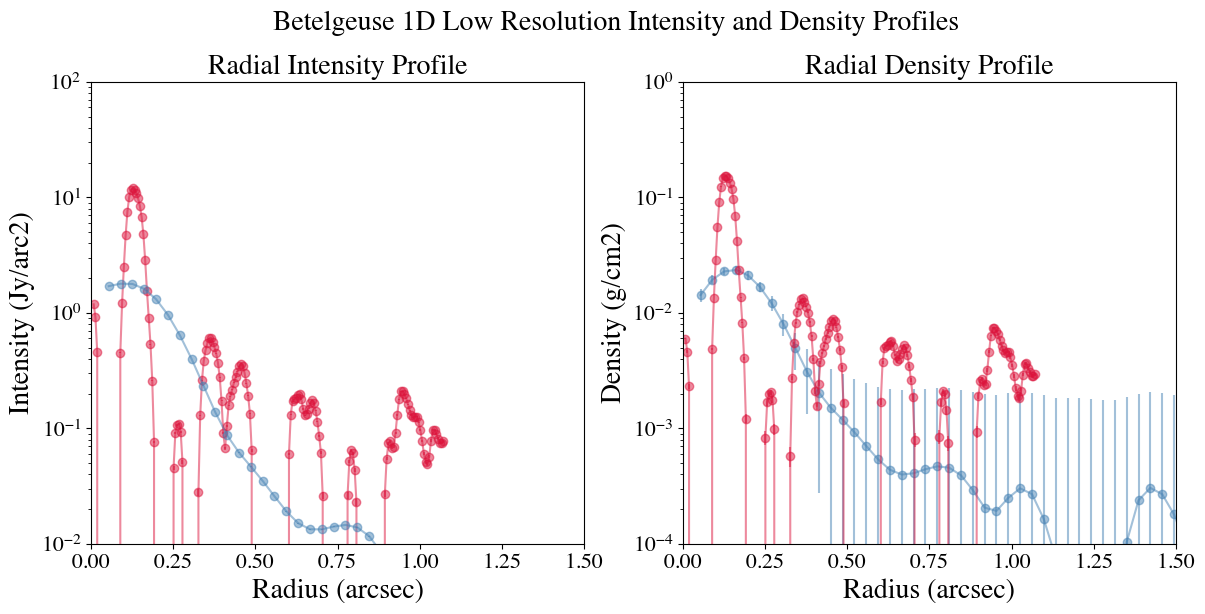

In [663]:
plt.style.use("default")
plt.rcParams["font.family"] = "times"
plt.rcParams.update({'font.size': 16})
text_size = 20

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [14,6])
fig.suptitle('Betelgeuse 1D Low Resolution Intensity and Density Profiles',size = 20,y=1)

ax1.errorbar(hr_rp_radius['arc'],rp_hr['jy/arc2'].value,yerr= np.abs(info_hr['median_jy/arc2'].value),color=highcolor,label = 'High Res',zorder = 0, alpha=0.5,fmt='-o')

ax1.errorbar(lr_rp_radius['arc'],rp_lr['jy/arc2'].value,yerr = np.abs(info_lr['median_jy/arc2'].value),color=lowcolor,label = 'Low Res',zorder=0, alpha=0.5,fmt= 'o-')
ax1.semilogy()
ax1.set_xlim(0, 1.5)
ax1.set_ylim(1e-2,1e2)

ax1.set_title("Radial Intensity Profile",size=text_size)
ax1.set_xlabel("Radius (arcsec)",size=text_size)
ax1.set_ylabel("Intensity (Jy/arc2)",size=text_size)

ax2.set_title("Radial Density Profile",size=text_size)
ax2.errorbar(lr_rp_radius['arc'],num_1d_model_lr.value, yerr = np.abs(info_hr['median_jy/arc2'].value), color = lowcolor,zorder = 0, alpha=0.5,fmt='-o')
ax2.errorbar(hr_rp_radius['arc'],num_1d_model_hr.value, yerr = np.abs(info_lr['median_jy/arc2'].value), color = highcolor,zorder=0, alpha=0.5,fmt= 'o-')
ax2.set_xlabel("Radius (arcsec)",size=text_size)
ax2.set_ylabel("Density (g/cm2)",size=text_size)
ax2.semilogy()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(1e-4,1)
plt.show()

bmajpix, bminpix:  37.708688084491534 32.44126558022007
bmajsigma, bminsigma:  16.01340542520986 13.776537043107128
convolution complete.
starting reprojection...


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


data_hr:  0.5752931237220764
convovled_hr_pix:  0.607574462890625
reproj_hr_pix:  0.6263349477119132
reproj_hr_pix_norm:  0.38142818872863166

reproj_hr_arc:  15.495853170315392
reproj_hr_arc_norm:  9.436732261468547
<class 'astropy.units.quantity.Quantity'> <class 'astropy.units.quantity.Quantity'>
 id xcentroid ycentroid sharpness roundness1 roundness2 npix sky  peak flux  mag 
--- --------- --------- --------- ---------- ---------- ---- ---- ---- ---- -----
  1    439.90    440.92      0.41      -0.18      -0.01   25 0.00 0.01 6.92 -2.10
439 442
(441, 440)


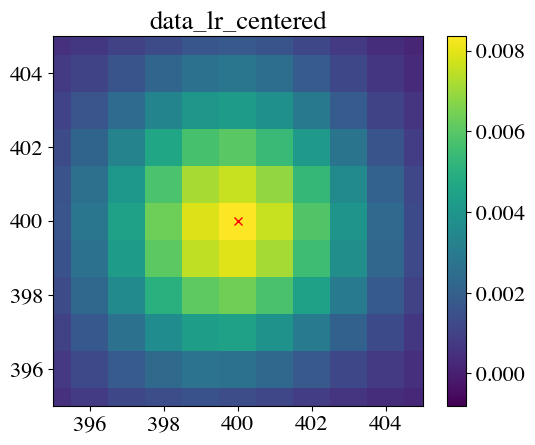

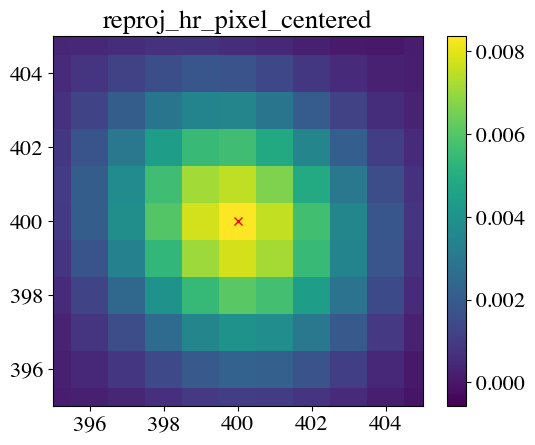

stop 2


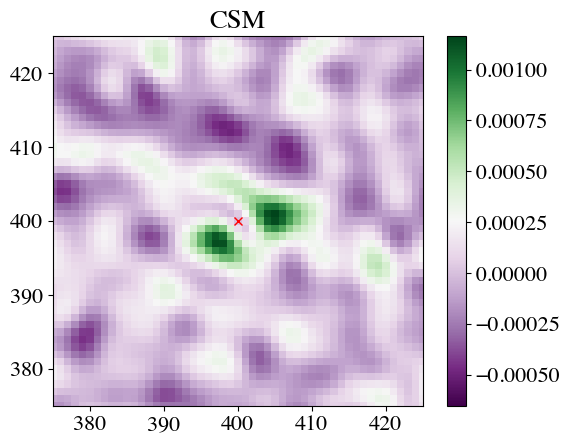

stop 3


In [664]:
data_conv_norm, data_conv, data_centered, data_csm, info_conv = convolve_resamp(data_lr, data_hr, info_lr, info_hr)

In [665]:
w

400

In [666]:
rp_lr_centered = rp_annulus(data_centered['lr'], info_lr['pix_size_arcsec'], (w,w))
rp_conv_resampled_centered = rp_annulus(data_centered['convhr'], info_lr['pix_size_arcsec'], (w,w))
rp_csm_pix= rp_annulus(data_csm['jy/pix'], info_lr['pix_size_arcsec'],(w,w))
rp_conv_not_norm = rp_annulus(data_conv['jy/arc2'][0,0,...],info_lr['pix_size_arcsec'],info_conv['position'])


In [667]:
x=int(info_lr['position'][0])
y=int(info_lr['position'][1])
w=400
data_lr_centered = data_lr['jy/pixel'][0,0,x-w:x+w,y-w:y+w]
print(x,y)
reproj_hr_pixel_centered = data_conv_norm['jy/pixel'][0,0,info_conv['position'][0]-w:info_conv['position'][0]+w,info_conv['position'][1]-w:info_conv['position'][1]+w]



439 442


In [668]:
reproj_hr_pixel_centered.shape

(800, 800)

In [669]:
data_lr_centered.shape

(800, 800)

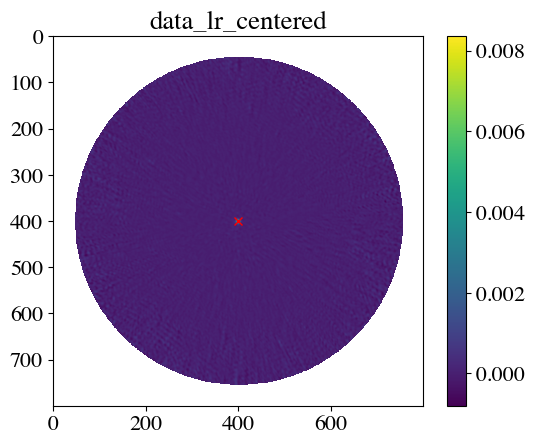

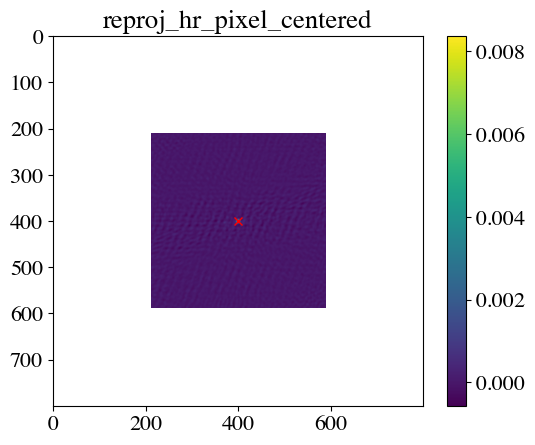

In [670]:
plt.title("data_lr_centered")
plt.imshow(data_lr_centered.transpose())

plt.plot(w,w,'rx')
err=5
# plt.xlim(200-err,200+err)
# plt.ylim(200-err,200+err)
plt.colorbar()
plt.show()

plt.title("reproj_hr_pixel_centered")
plt.imshow(reproj_hr_pixel_centered.transpose())
plt.plot(w,w,'rx')
# plt.xlim(200-err,200+err)
# plt.ylim(200-err,200+err)
plt.colorbar()
plt.show()

In [671]:
csm = data_lr_centered - (reproj_hr_pixel_centered)
#csm = data_lr['jy/pixel'][0,0,...]-reproj_hr_pixel_norm[0,0,...]


csm_jy_arc = csm/(beam_solid_angle_lr.to(u.arcsec**2).value)

# plt.plot(data_lr_centered, label = 'lr', c = lowcolor)
# plt.plot(reproj_hr_pixel_centered, label = 'hrconv', c='maroon')
# plt.plot(csm, 'o-', label='CSM', zorder=9,c='purple')
# plt.legend()

# plt.xlim(0,1.5)
# plt.semilogy()
# plt.show()

print("stop 2")

stop 2


In [672]:
csm.shape

(800, 800)

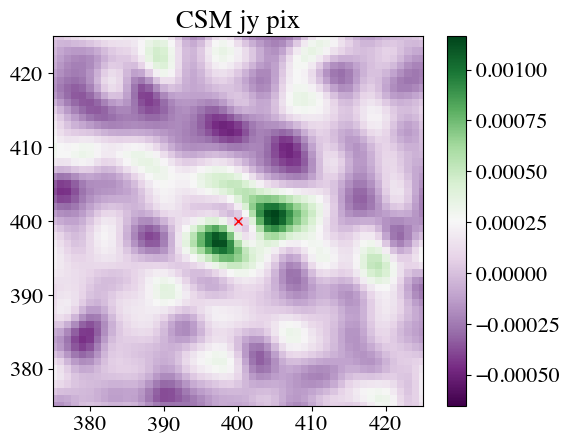

In [673]:
plt.imshow(csm.value, origin = 'lower',cmap = 'PRGn')
plt.title("CSM jy pix")
plt.plot(w, w,'rx')
# plt.plot(info_hr['position'][0],info_hr['position'][1],'o')
err=25
plt.colorbar()
plt.xlim(w-err,w+err)
plt.ylim(w-err,w+err)
plt.show()

In [674]:
rp_lr_centered = rp_annulus(data_centered['lr'], info_lr['pix_size_arcsec'], (w,w))
rp_conv_resampled_centered = rp_annulus(data_centered['convhr'], info_lr['pix_size_arcsec'], (w,w))
rp_csm_pix= rp_annulus(data_csm['jy/pix'], info_lr['pix_size_arcsec'],(w,w))
rp_conv_not_norm = rp_annulus(data_conv['jy/pixel'][0,0,...],info_lr['pix_size_arcsec'],info_conv['position'])

In [ ]:
aperture_size = r_betelgeuse.value / info_lr['pix_size_arcsec'].value #put in pixel units
aperture = CircularAperture(position,aperture_size)
photometry = aperture_photometry(data_lr_centered,aperture)
# print()
# print("Photometry: ", photometry)

aperture_sizes = np.arange(1,200,1)
annuli=[CircularAnnulus(position, r_in=aperture_sizes[i], r_out=aperture_sizes[i+1]) for i in range(len(aperture_sizes)-1)]
areas = np.array([circle.area for circle in annuli])*info_lr['pix_size_arcsec']**2
# print(apertures)


photometry = aperture_photometry(data_lr_centered, annuli)
phot_list = []
for k,v in photometry.items():
    if 'aperture_sum' in k:
        phot_list.append(v)
phot_array = np.array(phot_list)
#print(phot_list)
surf_brightness_jy_arc2 = phot_array.flatten()*u.Jy / (areas)

centers_arc = ((aperture_sizes[1:]+aperture_sizes[:-1])/2)*info_lr['pix_size_arcsec']
centers_pc = sm(168,centers_arc).value*u.pc

centers = {'pc': centers_pc, 'arc': centers_arc}


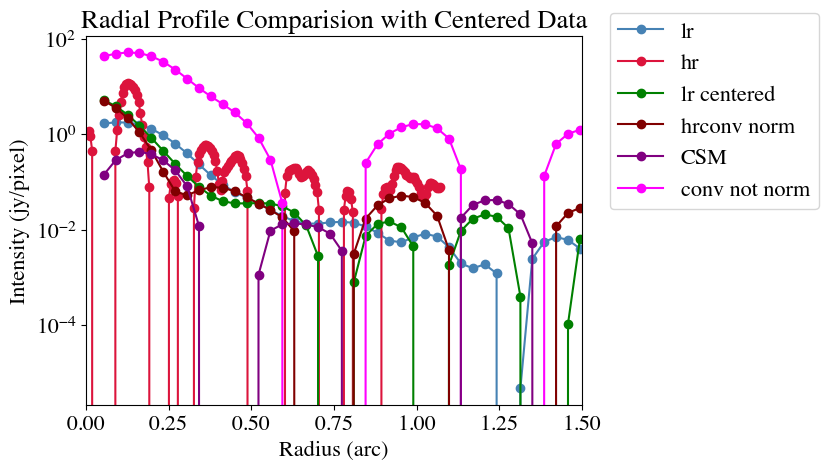

In [626]:
plt.plot(rp_lr_pix[0]['arc'],rp_lr_pix[1].value,'o-', label = 'lr', c = lowcolor)
plt.plot(rp_hr_pix[0]['arc'],rp_hr_pix[1].value,'o-', label = 'hr', c = highcolor)

plt.plot(rp_lr_centered[0]['arc'],rp_lr_centered[1].value,'o-', label = 'lr centered', c = 'green')
plt.plot(rp_conv_resampled_centered[0]['arc'],rp_conv_resampled_centered[1].value,'o-', label = 'hrconv norm', c='maroon')
plt.plot(rp_csm_pix[0]['arc'], rp_csm_pix[1].value, 'o-', label='CSM', zorder=9,c='purple')
plt.plot(rp_conv_not_norm[0]['arc'],rp_conv_not_norm[1].value,'o-',label='conv not norm', color = 'fuchsia')
plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.xlim(0,1.5)
plt.semilogy()
plt.title('Radial Profile Comparision with Centered Data')
plt.xlabel('Radius (arc)')
plt.ylabel('Intensity (jy/pixel)')
plt.show()

In [1]:
plt.plot(rp_lr_pix[0]['arc'],rp_lr_pix[1].value,'o-', label = 'lr', c = lowcolor)
#plt.plot(rp_hr_pix[0]['arc'],rp_hr_pix[1].value,'o-', label = 'hr', c = highcolor)

plt.plot(rp_lr_centered[0]['arc'],rp_lr_centered[1].value,'o-', label = 'lr centered', c = 'green')
plt.plot(rp_conv_resampled_centered[0]['arc'],rp_conv_resampled_centered[1].value,'o-', label = 'hrconv norm', c='maroon')
#plt.plot(rp_csm_pix[0]['arc'], rp_csm_pix[1].value, 'o-', label='CSM', zorder=9,c='purple')
plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.xlim(0,1.5)
plt.semilogy()
plt.title('Radial Profile Comparision with Centered Data')
plt.xlabel('Radius (arc)')
plt.ylabel('Intensity (jy/pixel)')
plt.show()

NameError: name 'plt' is not defined

In [622]:
rp_lr_pix = rp_annulus(data_lr['jy/pixel'][0,0,...], info_lr['pix_size_arcsec'], info_lr['position'])
rp_hr_pix = rp_annulus(data_hr['jy/pixel'][0,0,...], info_hr['pix_size_arcsec'], info_hr['position'])


In [629]:
data_centered['lr'][400,400]

<Quantity 0.00836175>

In [631]:
data_lr['jy/pixel'][0,0,info_lr['position'][0],info_lr['position'][1]]

<Quantity 0.00836175>

In [632]:
info_lr['position'][0],info_lr['position'][1]

(439, 442)

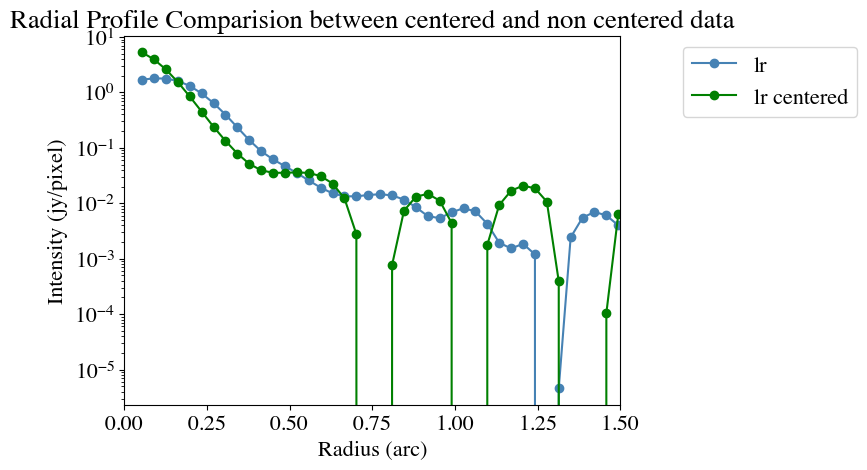

In [650]:
plt.plot(rp_lr_pix[0]['arc'],rp_lr_pix[1].value,'o-', label = 'lr', c = lowcolor)
plt.plot(rp_lr_centered[0]['arc'],rp_lr_centered[1].value,'o-', label = 'lr centered', c = 'green')
# plt.plot(rp_conv_resampled_centered[0]['arc'],rp_conv_resampled_centered[1].value,'o-', label = 'hrconv norm', c='maroon')
# plt.plot(rp_csm_pix[0]['arc'], rp_csm_pix[1].value, 'o-', label='CSM', zorder=9,c='purple')
# plt.plot(rp_conv_not_norm[0]['arc'],rp_conv_not_norm[1].value,'o-',label='conv not norm', color = 'green')
plt.legend(loc = 'best', bbox_to_anchor=(1, 0.5, 0.5, 0.5))
plt.xlim(0,1.5)
plt.semilogy()
plt.title('Radial Profile Comparision between centered and non centered data')
plt.xlabel('Radius (arc)')
plt.ylabel('Intensity (jy/pixel)')
plt.show()

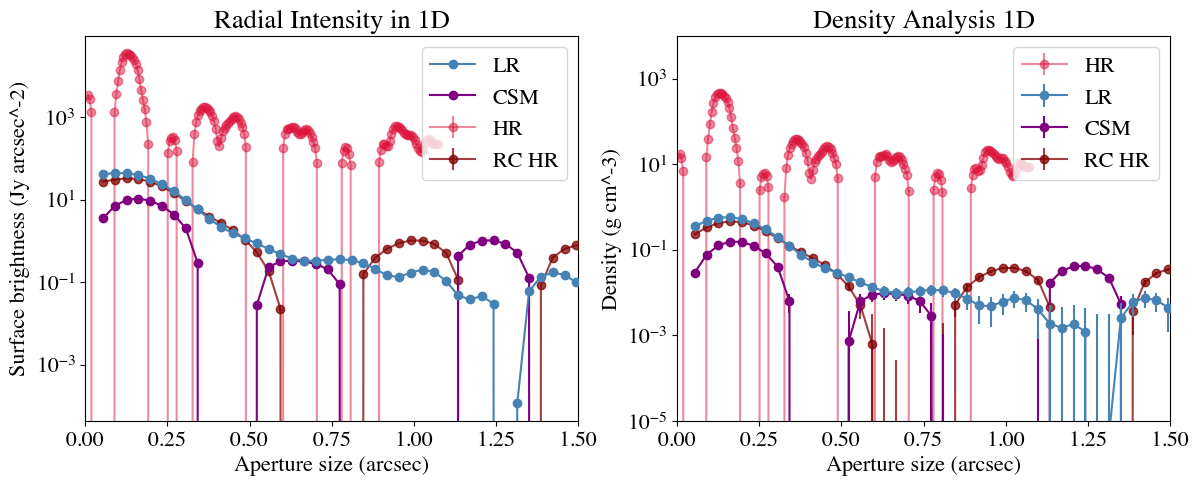

In [547]:

hr_rms_arc = np.nanstd(data_hr['jy/arc2'][0,0][data_hr['jy/arc2'][0,0]<1])
lr_rms_arc = np.nanstd(data_lr['jy/arc2'][0,0][data_lr['jy/arc2'][0,0]<1])
csm_rms_arc = np.nanstd(data_csm['jy/arc2'][data_csm['jy/arc2']<1])
hr_conv_resampled_rms_arc = np.nanstd(data_conv_norm['jy/arc2'][0,0,...][data_conv_norm['jy/arc2'][0,0,...]<0.1])

rp_lr = rp_annulus(data_lr['jy/arc2'][0,0,...], info_lr['pix_size_arcsec'], info_lr['position'])
rp_hr = rp_annulus(data_hr['jy/arc2'][0,0,...], info_hr['pix_size_arcsec'], info_hr['position'])
rp_csm = rp_annulus(data_csm['jy/arc2'], info_lr['pix_size_arcsec'],(200,200))
rp_conv_resampled = rp_annulus(data_conv_norm['jy/arc2'][0,0,...],info_lr['pix_size_arcsec'],info_conv['position'])

hr_1d_density = density_model(rp_hr[1],rp_hr[0]['pc'])
lr_1d_density = density_model(rp_lr[1],rp_lr[0]['pc'])
csm_1d_density = density_model(rp_csm[1],rp_csm[0]['pc'])
hr_conv_resampled_1d_density = density_model(rp_conv_resampled[1],rp_conv_resampled[0]['pc'])

## plotting 1d results

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [14,5])

ax1.set_title("Radial Intensity in 1D")
ax1.errorbar(rp_hr[0]['arc'], rp_hr[1].value, yerr = hr_rms_arc.value, #np.sqrt(np.sqrt(rp_hr[1].value)**2 + hr_rms**2), 
             fmt='o-', label='HR', zorder=0, alpha=0.5,c=highcolor)

ax1.plot(rp_lr[0]['arc'], rp_lr[1], 'o-', label='LR', zorder=10,c=lowcolor)
ax1.plot(rp_csm[0]['arc'], rp_csm[1], 'o-', label='CSM', zorder=9,c='purple')
ax1.errorbar(rp_conv_resampled[0]['arc'], rp_conv_resampled[1].value, yerr=hr_conv_resampled_rms_arc.value, #np.sqrt(rp_conv_resampled[1].value) + hr_conv_resampled_rms,
               fmt='o-', label='RC HR', zorder=8, alpha=0.75,c='maroon')

ax1.set_xlabel("Aperture size (arcsec)")
ax1.set_ylabel("Surface brightness (Jy arcsec^-2)")
ax1.legend(loc = 'upper right')
ax1.set_xlim(0, 1.5)
ax1.semilogy()
# ax1.ylim(1e-1, 1e7)
#ax1.ylim(-50,1e2)
 

ax2.set_title("Density Analysis 1D")
ax2.errorbar(rp_hr[0]['arc'], hr_1d_density.value, yerr = hr_rms_arc, #np.sqrt(np.sqrt(rp_hr[1].value)**2 + hr_rms**2), 
             fmt='o-', label='HR', zorder=0, alpha=0.5, c = highcolor)

ax2.errorbar(rp_lr[0]['arc'], lr_1d_density.value,yerr = lr_rms_arc, fmt = 'o-', label='LR', zorder=10, c = lowcolor)#yerr = lr_rms_arc
ax2.errorbar(rp_csm[0]['arc'],csm_1d_density.value, yerr=csm_rms_arc,fmt='o-', label='CSM', zorder=9, c = 'purple')
ax2.errorbar(rp_conv_resampled[0]['arc'], hr_conv_resampled_1d_density.value, yerr=hr_conv_resampled_rms_arc.value, #np.sqrt(rp_conv_resampled[1].value) + hr_conv_resampled_rms,
               fmt='o-', label='RC HR', zorder=8, alpha=0.75,color = 'maroon')

ax2.set_xlabel("Aperture size (arcsec)")
ax2.set_ylabel("Density (g cm^-3)")
ax2.legend(loc = 'upper right')
ax2.semilogy()
ax2.set_xlim(0, 1.5)
ax2.set_ylim(1e-5, 1e4)# 
# ax2.xlim(0, 4)
# ax2.ylim(-8.51,8)
plt.show()

In [458]:
radius_csm_2d_arc = radius2d(data_csm['jy/arc2'])*info_lr['pix_size_arcsec']#*u.arcsec
radius_csm_2d_pc = sm(168,radius_csm_2d_arc.value)*u.pc

lr_2d_density = density_model(data_lr['jy/arc2'][0,0,...],lr_radius_2d['pc'])
hr_2d_density = density_model(data_hr['jy/arc2'][0,0,...],hr_radius_2d['pc'])

/Users/iman/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [511]:
hr_conv_2d_density = density_model(data_conv_norm['jy/arc2'][0,0,...],lr_radius_2d['pc'])
csm_2d_density = density_model(data_csm['jy/arc2'],radius_csm_2d_pc)

hr_dens_rms_arc_2d = np.nanstd(hr_2d_density.value[hr_2d_density.value<1])
lr_dens_rms_arc_2d = np.nanstd(lr_2d_density.value[lr_2d_density.value<1])
#hr_dens_conv_rms_arc = np.nanstd(result_jy_arc[result_jy_arc<1.0])
hr_dens_conv__rms_arc_2d = np.nanstd(hr_conv_2d_density.value[hr_conv_2d_density.value<0.1])
csm_dens_rms_arc_2d = np.nanstd(csm_2d_density.value[csm_2d_density.value<1])

/Users/iman/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


ValueError: operands could not be broadcast together with shapes (882,882) (400,400) 

In [460]:
hdu_lr_2d_i = fits.PrimaryHDU(data_lr['jy/arc2'][0,0,...].value)
hdu_lr_2d_i.writeto('fits/lr_jy_arc2.fits',overwrite=True)
hdu_lr_2d_d = fits.PrimaryHDU(lr_2d_density.value)
hdu_lr_2d_d.writeto('fits/lr_jy_arc2_DENS.fits',overwrite=True)

hdu_hr_2d_i = fits.PrimaryHDU(data_hr['jy/arc2'][0,0,...].value)
hdu_hr_2d_i.writeto('fits/hr_jy_arc2.fits',overwrite=True)
hdu_hr_2d_d = fits.PrimaryHDU(hr_2d_density.value)
hdu_hr_2d_d.writeto('fits/hr_jy_arc2_DENS.fits',overwrite=True)

hdu_hrrc_2d_i = fits.PrimaryHDU(data_conv_norm['jy/arc2'][0,0,...].value)
hdu_hrrc_2d_i.writeto('fits/conv_jy_arc2.fits',overwrite=True)
hdu_hrrc_2d_d = fits.PrimaryHDU(hr_conv_2d_density.value)
hdu_hrrc_2d_d.writeto('fits/conv_jy_arc2_DENS.fits',overwrite=True)

hdu_csm_2d_i = fits.PrimaryHDU(data_csm['jy/arc2'].value)
hdu_csm_2d_i.writeto('fits/csm_jy_arc2.fits',overwrite=True)
hdu_csm_2d_d = fits.PrimaryHDU(csm_2d_density.value)
hdu_csm_2d_d.writeto('fits/csm_jy_arc2_DENS.fits',overwrite=True)

In [461]:
data_sets = [data_hr['jy/arc2'][0,0,...], data_lr['jy/arc2'][0,0,...], data_conv['jy/arc2'][0,0,...], data_csm['jy/arc2'].value, 
             hr_2d_density.value, lr_2d_density.value, hr_conv_2d_density.value, csm_2d_density.value]
info_reproj={'pix_size_arcsec': info_lr['pix_size_arcsec'],'position': info_conv['position']}
info_csm={'pix_size_arcsec': info_lr['pix_size_arcsec'],'position': (200,200)}

info_sets = [info_hr, info_lr, info_reproj, info_csm,info_hr, info_lr, info_reproj, info_csm]
titles = ["HR Data", "LR Data", "Conv After Reprojection", "Circumstellar Material", 
          "HR Density", "LR Density", "HR Conv Resampled Density", "CSM Density"]

In [491]:
np.nanmin(data_csm['jy/arc2'])

<Quantity -0.02609261>

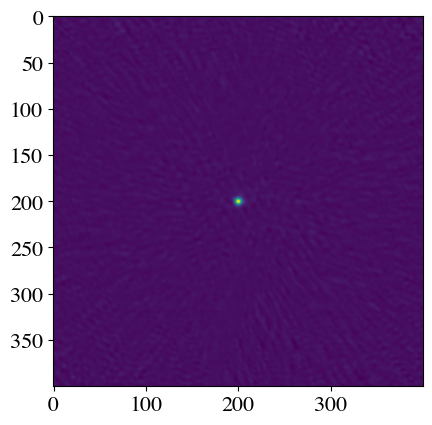

In [505]:
plt.imshow(data_centered['lr'])

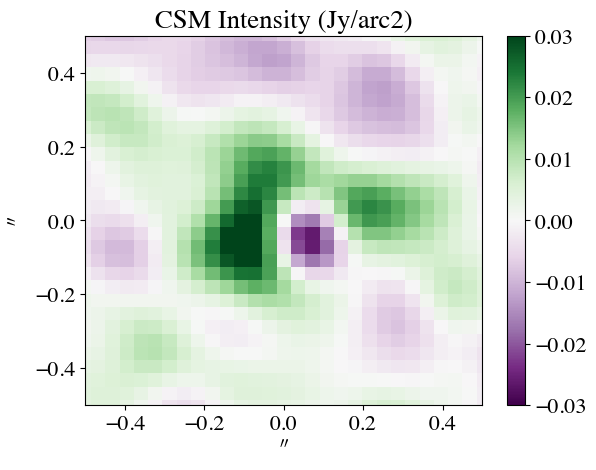

In [546]:
# xaxis = range(data_csm['jy/arc2'].shape[0])*info_csm['pix_size_arcsec']-((info_lr['position'][1])*info_csm['pix_size_arcsec'])
# yaxis = range(data_csm['jy/arc2'].shape[1])*info_csm['pix_size_arcsec']-((info_lr['position'][0])*info_csm['pix_size_arcsec'])

xaxis = range(data_csm['jy/arc2'].shape[0])*info_csm['pix_size_arcsec']-((info_csm['position'][1])*info_csm['pix_size_arcsec'])
yaxis = range(data_csm['jy/arc2'].shape[1])*info_csm['pix_size_arcsec']-((info_csm['position'][0])*info_csm['pix_size_arcsec'])

plt.pcolormesh(xaxis,yaxis,data_csm['jy/arc2'],cmap='PRGn',vmin=-0.03,vmax=0.03)
err=0.5

plt.xlim(-err,err)
plt.ylim(-err,err)
# plt.xlim(info_csm['position'][0]-err,info_csm['position'][0]+err)
# plt.ylim(info_csm['position'][1]-err,info_csm['position'][1]+err)
plt.title("CSM Intensity (Jy/arc2)")
plt.colorbar()
plt.show()


In [497]:
import cmasher as cmr


In [464]:
info_lr['position'][0]

439

In [465]:
data_lr['jy/beam'][int(info_lr['position'][0]),int(info_lr['position'][1])]

0.26078528

In [466]:
info_lr['position']

(439, 442)

In [467]:
info_sets[0]['position']

(1273, 1290)

In [642]:
i=0
range(data_sets[i].shape[0])#*info_sets[i]['pix_size_arcsec']#-((info_sets[i]['position'][1])*info_sets[i]['pix_size_arcsec'])

range(0, 2560)

In [641]:
info_sets[i]['pix_size_arcsec']

<Quantity 0.0054 arcsec>

(1273, 1290)


1283.0339999946548 0.0
(439, 442)
426.08800001818264 0.0
(440, 443)
427.0520000182238 0.0
(200, 200)
192.80000000822744 0.0
(1273, 1290)
1283.0339999946548 0.0
(439, 442)
426.08800001818264 0.0
(440, 443)
427.0520000182238 0.0
(200, 200)
192.80000000822744 0.0


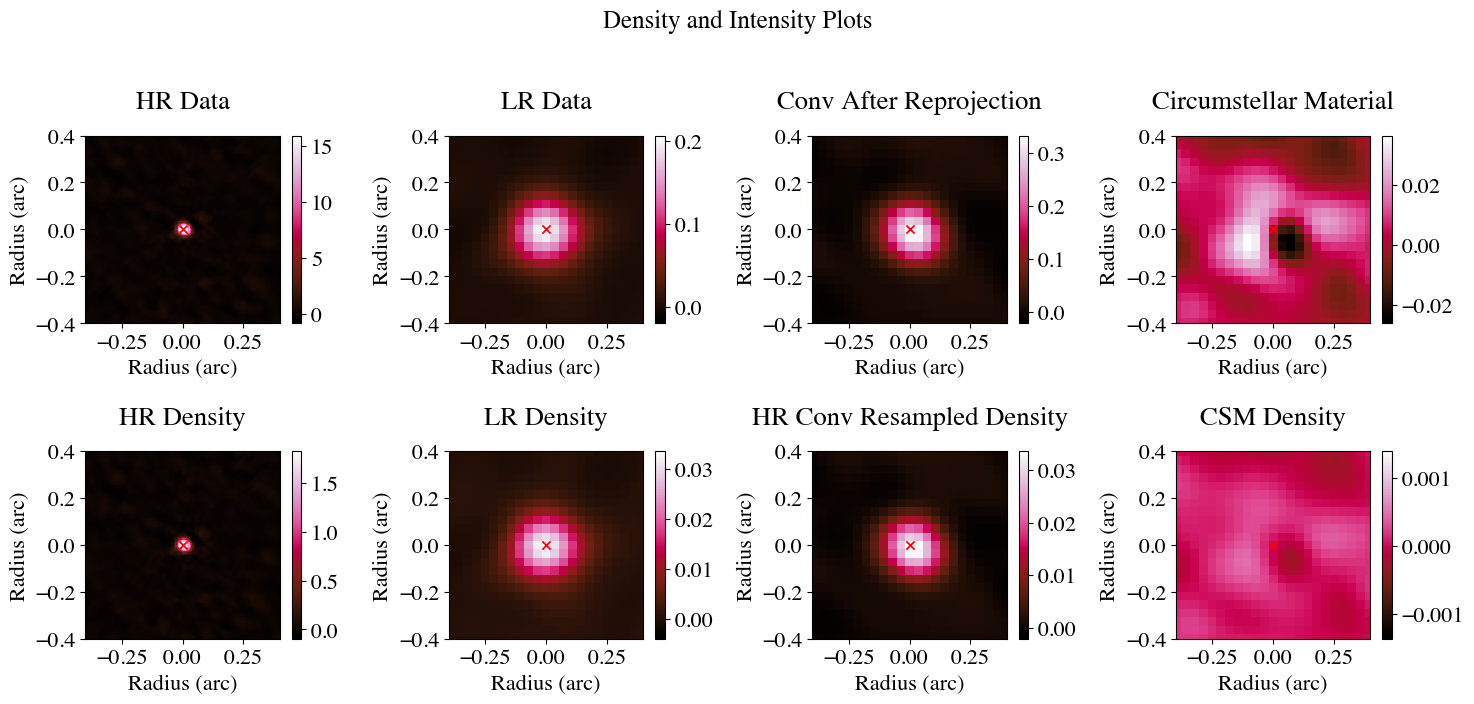

In [468]:
minn=-0.4
maxx=-minn
figure,axs = plt.subplots(nrows = 2, ncols=4, figsize = (15,7))#, subplot_kw={'projection': wcs})
figure.suptitle("Density and Intensity Plots", fontsize = 18, y=1.01)

for i,ax in zip(range(len(data_sets)), axs.ravel()):
     range(data_sets[i].shape[0])
     info_sets[i]['pix_size_arcsec']
     print(info_sets[i]['position'])

     xaxis = range(data_sets[i].shape[0])*info_sets[i]['pix_size_arcsec']-((info_sets[i]['position'][1])*info_sets[i]['pix_size_arcsec'])
     yaxis = range(data_sets[i].shape[1])*info_sets[i]['pix_size_arcsec']-((info_sets[i]['position'][0])*info_sets[i]['pix_size_arcsec'])
     
     im = ax.pcolormesh(xaxis,yaxis,data_sets[i], cmap=cmr.flamingo,shading="nearest")
     ax.plot((info_sets[i]['position'][1])*info_sets[i]['pix_size_arcsec']-((info_sets[i]['position'][1])*info_sets[i]['pix_size_arcsec']),
             (info_sets[i]['position'][0])*info_sets[i]['pix_size_arcsec']-((info_sets[i]['position'][0])*info_sets[i]['pix_size_arcsec']),'rx')
     print((info_sets[i]['position'][1])-(info_sets[i]['position'][1])*info_sets[i]['pix_size_arcsec'].value,
             (info_sets[i]['position'][0])*info_sets[i]['pix_size_arcsec'].value-((info_sets[i]['position'][0])*info_sets[i]['pix_size_arcsec'].value))
     ax.plot(0,0,'rx')

     ax.set_title(titles[i], y =1.1)
     ax.set_xlim(minn, maxx)
     ax.set_ylim(minn, maxx)
     fig.colorbar(im,ax=ax)
     ax.set_xlabel("Radius (arc)")
     ax.set_ylabel("Radius (arc)")

figure.tight_layout(pad = 1)
plt.show()
